# Set up

In [2]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [3]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "classification"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# MNIST

In this chapter we will be using the MNIST dataset, which is a set of 70,000 small images of digits handwritten by high school students and employees of the US Census Bureau. Each image is labeled with the digit it represents.

In [4]:
import numpy as np
from sklearn.datasets import fetch_openml # download real-life datasets

np.random.seed(42)

mnist = fetch_openml('mnist_784', as_frame=False)

X, y = mnist.data, mnist.target

In [5]:
print(mnist.DESCR)

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

In [6]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [7]:
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [8]:
y

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

In [9]:
X.shape

(70000, 784)

In [10]:
y.shape

(70000,)

There are 70,000 images, and each image has 784 features. This is because each image is 28 × 28 pixels, and each feature simply represents one pixel’s intensity, from 0 (white) to 255 (black). Let’s take a peek at one digit from the dataset and display it using Matplotlib’s `imshow()` function. We use `cmap="binary"` to get a grayscale color map where 0 is white and 255 is black:

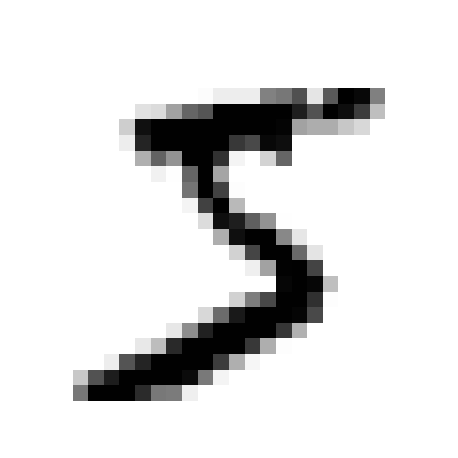

In [11]:
def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

some_digit = X[0]
plot_digit(some_digit)
save_fig("some_digit_plot")  # extra code
plt.show()

In [12]:
y[0]

'5'

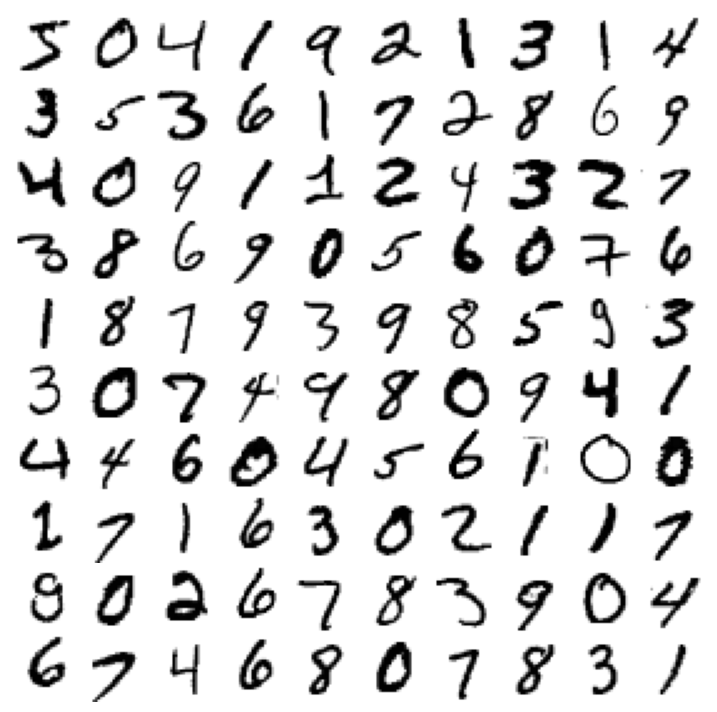

In [13]:
plt.figure(figsize=(9, 9))
for idx, image_data in enumerate(X[:100]):
    plt.subplot(10, 10, idx + 1)
    plot_digit(image_data)
plt.subplots_adjust(wspace=0, hspace=0)
save_fig("more_digits_plot", tight_layout=False)
plt.show()

In [14]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:] # split the data into training and test sets

# Training a Binary Classifier

First, we need to simplify problem and only try to identify one digit. "5-detector" will be an example of classifier a binary classifier.

In [15]:
y_train_5 = (y_train == '5') # True for all 5s, False for all other digits
y_test_5 = (y_test == '5')

Now let’s pick a classifier and train it. A good place to start is using a stochastic gradient descent [`Scikit-Learn’s SGDClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) class.

In [16]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [17]:
sgd_clf.predict([X[0]])

array([ True])

# Performance Measures

## Measuring Accuracy Using Cross-Validation

Let’s use the `cross_val_score()` function to evaluate our `SGDClassifier` model, using k-fold cross-validation with three folds. Remember that k-fold cross-validation means splitting the training set into k folds (in this case, three), then training the model k times, holding out a different fold each time for evaluation.

In [18]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy') # 3-fold cross-validation, accuracy as scoring metric

array([0.95035, 0.96035, 0.9604 ])

Implementing Cross-Validation:

In [19]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print((n_correct / len(y_pred)))

0.9669
0.91625
0.96785


`Stratifiedkfold` is a tool in the Scikit-learn library used to divide data into training and tests during cross-validation. The special feature of `stratifiedkfold` is that it retains the distribution of layers in data when divided into folds.

When using `stratifiedkfold`, you specify the number of fold (`n_splits`) you want to create. Each fold will be made so that the proportion of layers in the data is originally maintained. This ensures that each fold has a good representation for different classes in data.

For example, if you have a set of data with 100 models and 2 layers (class 0 and 1), and you want to divide into 5 folds, `stratifiedkfold` will divide data so that each fold has 80% of the model of class 0 And 20% of the sample of grade 1. This helps ensure that each fold has a good representation for both classes.

To use `StratifiedKFold`, you need to transfer training data (`x`) and the corresponding label (`y`) to the `split()` method. It will return the indicators of the samples in training and test for each fold. You can use these indicators to access the corresponding samples in the data.

In [20]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
print(any(dummy_clf.predict(X_train))) # prints False: no 5s detected

False


Dummy classifier just classifies every single image in the most frequent class, which in this case is the negative class (i.e., non 5):

In [21]:
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.90965, 0.90965, 0.90965])

It has over 90% accuracy! This is simply because only about 10% of the images are 5s, so if you always guess that an image is not a 5, you will be right about 90% of the time.

## Confustion Matrices

The general idea of a confusion matrix is to count the number of times instances of class A are classified as class B, for all A/B pairs. For example, to know the number of times the classifier confused images of 8s with 0s, you would look at row #8, column #0 of the confusion matrix.

To compute the confusion matrix, you first need to have a set of predictions so that they can be compared to the actual targets. You can use the `cross_val_predict()` function:

In [22]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
y_train_pred

array([ True, False, False, ...,  True, False, False])

Just like the `cross_val_score()` function, `cross_val_predict()` performs k-fold cross-validation, but instead of returning the evaluation scores, it returns the predictions made on each test fold. This means that you get a clean prediction for each instance in the training set.

Now you are ready to get the confusion matrix using the `confusion_matrix()` function. Just pass it the target classes (`y_train_5`) and the predicted classes (`y_train_pred`):

In [23]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]])

Each row in a confusion matrix represents an actual class, while each column represents a predicted class. The first row of this matrix considers non-5 images (the negative class): 53,892 of them were correctly classified as non-5s (they are called true negatives), while the remaining 687 were wrongly classified as 5s (false positives, also called type I errors). The second row considers the images of 5s (the positive class): 1,891 were wrongly classified as non-5s (false negatives, also called type II errors), while the remaining 3,530 were correctly classified as 5s (true positives). A perfect classifier would only have true positives and true negatives, so its confusion matrix would have nonzero values only on its main diagonal (top left to bottom right):

In [24]:
y_train_perfect_predictions = y_train_5  # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

An interesting one to look at is the accuracy of the positive predictions; this is called the precision of the classifier:

$$\text{precision} = \frac{\text{TP}}{\text{TP} + \text{FP}}$$

$\text{TP}$ is the number of true positives, and $\text{FP}$ is the number of false positives.

A trivial way to have perfect precision is to create a classifier that always makes negative predictions, except for one single positive prediction on the instance it’s most confident about. If this one prediction is correct, then the classifier has 100% precision (precision = 1/1 = 100%). Obviously, such a classifier would not be very useful, since it would ignore all but one positive instance. So, precision is typically used along with another metric named recall, also called sensitivity or the true positive rate (TPR): this is the ratio of positive instances that are correctly detected by the
classifier:

$$\text{recall} = \frac{\text{TP}}{\text{TP} + \text{FN}}$$

$\text{FN}$ is, of course, the number of false negatives.

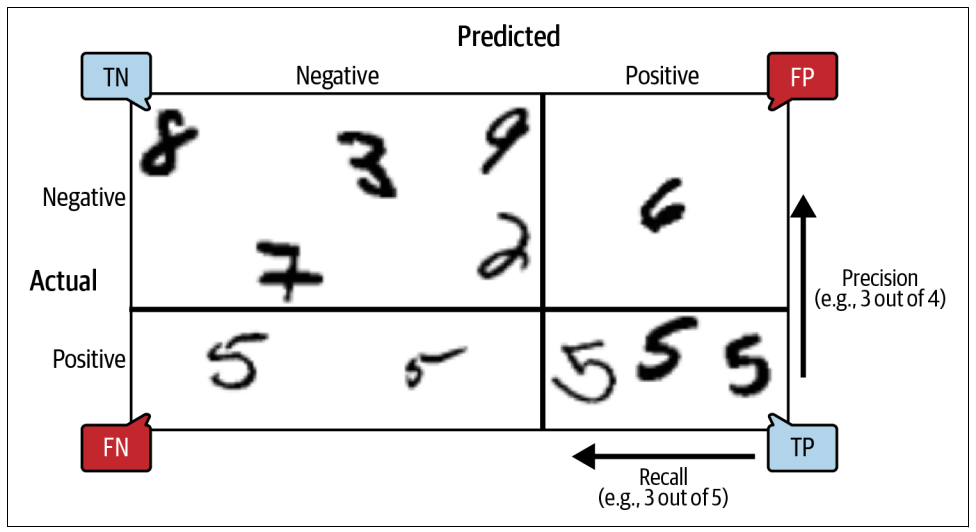

*Figure: An illustrated confusion matrix showing examples of true negatives (top left), false positives (top right), false negatives (lower left), and true positives (lower right)*

## Precision and Recall

Scikit-Learn provides several functions to compute classifier metrics, including precision and recall:

In [25]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)  # == 3530 / (687 + 3530)

0.8370879772350012

In [26]:
# extra code – this cell also computes the precision: TP / (FP + TP)
cm[1, 1] / (cm[0, 1] + cm[1, 1])

0.8370879772350012

In [27]:
recall_score(y_train_5, y_train_pred)  # == 3530 / (1891 + 3530)

0.6511713705958311

In [28]:
# extra code – this cell also computes the recall: TP / (FN + TP)
cm[1, 1] / (cm[1, 0] + cm[1, 1])

0.6511713705958311

When it claims an image represents a 5, it is correct only 83.7% of the time. Moreover, it only detects 65.1% of the 5s.

It is often convenient to combine precision and recall into a single metric called the F1 score, especially when you need a single metric to compare two classifiers. The F1 score is the harmonic mean of precision and recall. Whereas the regular mean treats all values equally, the harmonic mean gives much more weight to low values. As a result, the classifier will only get a high F1 score if both recall and
precision are high. *$F_1$ score:*

$$F_1 = \frac{2}{\frac{1}{\text{precision}} + \frac{1}{\text{recall}}} = 2\times\frac{\text{precision}\times\text{recall}}{\text{precision} + \text{recall}} = \frac{\text{TP}}{\text{TP} + \frac{\text{FN} + \text{FP}}{2}}$$

In [29]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343847

In [30]:
# extra code – this cell also computes the f1 score
cm[1, 1] / (cm[1, 1] + (cm[1, 0] + cm[0, 1]) / 2)

0.7325171197343847

## Precision/Recall Trade-off

To understand this trade-off, let’s look at how the SGDClassifier makes its classification decisions. For each instance, it computes a score based on a decision function. If that score is greater than a threshold, it assigns the instance to the positive class; otherwise it assigns it to the negative class.

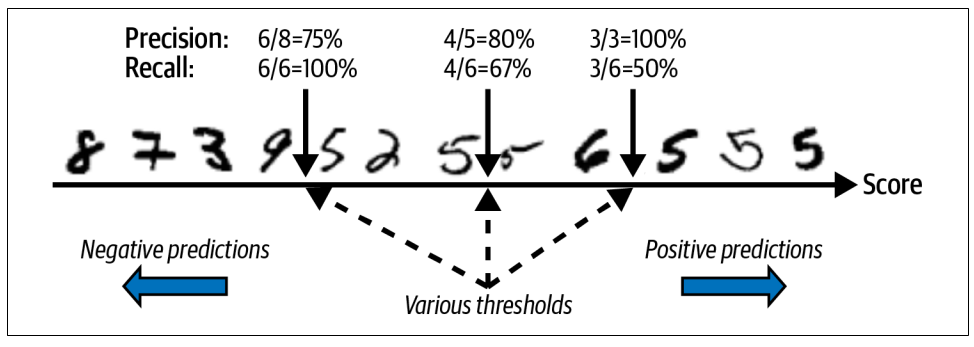

*Figure: The precision/recall trade-off: images are ranked by their classifier score, and those above the chosen decision threshold are considered positive; the higher the threshold, the lower the recall, but (in general) the higher the precision*

Scikit-Learn does not let you set the threshold directly, but it does give you access to the decision scores that it uses to make predictions. You can call its `decision_function()` method, which returns a score for each instance, and then use any threshold you want to make predictions based on those scores:

In [31]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

The `SGDClassifier` uses a threshold equal to 0, so the preceding code returns the same result as the `predict()` method (i.e., `True`). Let’s raise the threshold:

In [32]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [33]:
threshold = 3000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

How do you decide which threshold to use? First, use the `cross_val_predict()` function to get the scores of all instances in the training set:

In [34]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [35]:
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

With these scores, use the `precision_recall_curve()` function to compute precision and recall for all possible thresholds:

In [36]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [37]:
precisions

array([0.09035   , 0.09035151, 0.09035301, ..., 1.        , 1.        ,
       1.        ])

In [38]:
recalls

array([1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
       3.68935621e-04, 1.84467810e-04, 0.00000000e+00])

In [39]:
thresholds

array([-146348.56726174, -142300.00705404, -137588.97581744, ...,
         38871.26391927,   42216.05562787,   49441.43765905])

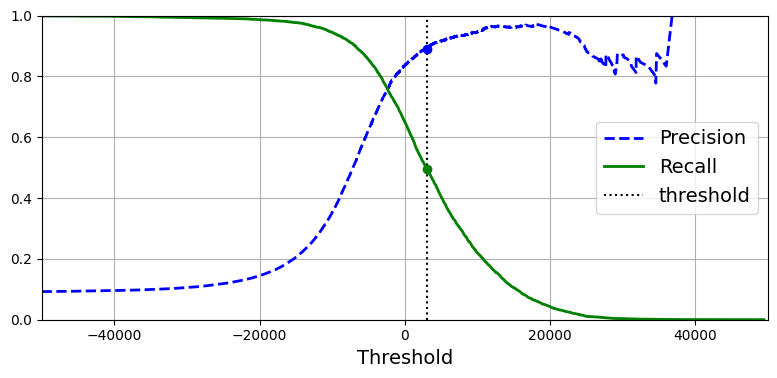

In [40]:
plt.figure(figsize=(8, 4))
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")

# extra code – this section just beautifies and saves Figure 3–5
idx = (thresholds >= threshold).argmax()  # first index ≥ threshold
plt.plot(thresholds[idx], precisions[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")
plt.axis([-50000, 50000, 0, 1])
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")
save_fig("precision_recall_vs_threshold_plot")

plt.show()

At this threshold value, precision is near 90% and recall is around 50%. You can search for the lowest threshold that gives you at least 90% precision.

In [41]:
idx_for_90_precision = (precisions >= 0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

3370.0194991439557

Another way to select a good precision/recall trade-off is to plot precision directly against recall:

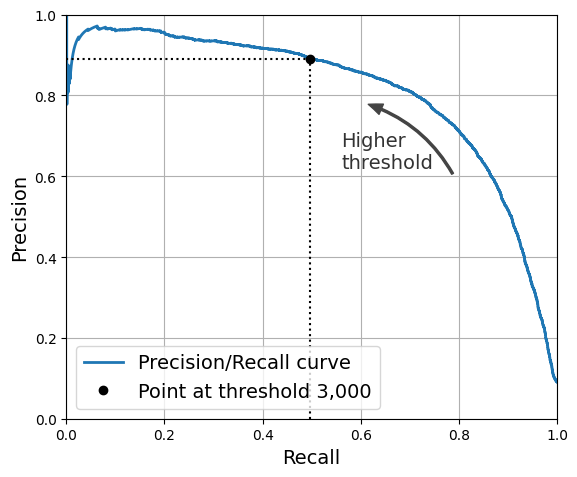

In [42]:
import matplotlib.patches as patches  # extra code – for the curved arrow

plt.figure(figsize=(6, 5)) 

plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")

# extra code – just beautifies and saves Figure 3–6
plt.plot([recalls[idx], recalls[idx]], [0., precisions[idx]], "k:")
plt.plot([0.0, recalls[idx]], [precisions[idx], precisions[idx]], "k:")
plt.plot([recalls[idx]], [precisions[idx]], "ko", label="Point at threshold 3,000")
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.79, 0.60), (0.61, 0.78),
    connectionstyle="arc3,rad=.2", # radius = 0.2
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.56, 0.62, "Higher\nthreshold", color="#333333")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")
save_fig("precision_vs_recall_plot")

plt.show()

To make predictions (on the training set for now), instead of calling the classifier’s `predict()` method, you can run this code:

In [43]:
y_train_pred_90 = (y_scores >= threshold_for_90_precision)

In [44]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [45]:
recall_at_90_precision = recall_score(y_train_5, y_train_pred_90)
recall_at_90_precision

0.4799852425751706

## The ROC Curve

The receiver operating characteristic (ROC) curve is another common tool used with binary classifiers. The ROC curve plots the true positive rate (another name for recall) against the false positive rate (FPR). The FPR is the ratio of negative instances that are incorrectly classified as positive. It is equal to 1 – the true negative rate (TNR), which is the ratio of negative instances that are correctly classified as negative. The TNR is also called specificity. Hence, the ROC curve plots sensitivity (recall) versus 1 – specificity.

To plot the ROC curve, you first use the `roc_curve()` function to compute the TPR and FPR for various threshold values:

In [46]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [48]:
fpr

array([0.        , 0.        , 0.        , ..., 0.99937705, 0.99937705,
       1.        ])

In [49]:
tpr

array([0.00000000e+00, 1.84467810e-04, 9.22339052e-04, ...,
       9.99815532e-01, 1.00000000e+00, 1.00000000e+00])

In [50]:
thresholds

array([             inf,   49441.43765905,   36801.60697028, ...,
       -105763.22240074, -106527.45300471, -146348.56726174])

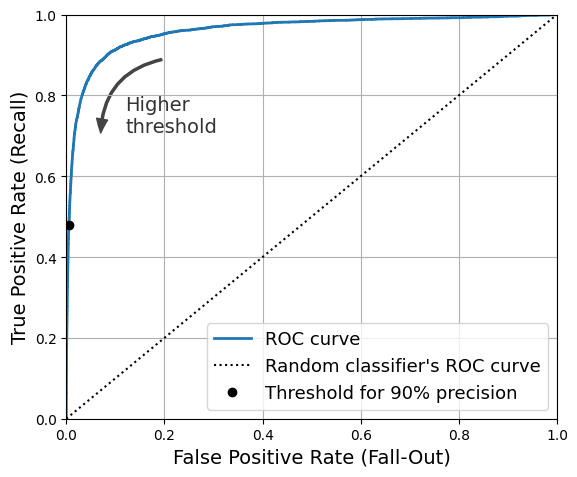

In [47]:
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.figure(figsize=(6, 5)) 
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")

plt.gca().add_patch(patches.FancyArrowPatch(
    (0.20, 0.89), (0.07, 0.70),
    connectionstyle="arc3,rad=.4",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.12, 0.71, "Higher\nthreshold", color="#333333")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13)
save_fig("roc_curve_plot")

plt.show()

_Figure: A ROC curve plotting the false positive rate against the true positive rate for all possible thresholds; the black circle highlights the chosen ratio (at 90% precision and 48% recall)_

One way to compare classifiers is to measure the area under the curve (AUC). A perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5. Scikit-Learn provides a function to estimate the ROC AUC:

In [51]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

Let’s now create a `RandomForestClassifier`, whose PR curve and F1 score we can compare to those of the `SGDClassifier`:

In [52]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

The `precision_recall_curve()` function expects labels and scores for each instance, so we need to train the random forest classifier and make it assign a score to each instance. But the `RandomForestClassifier` class does not have a `decision_function()` method, due to the way it works. Luckily, it has a `predict_proba()` method that returns class probabilities for each instance, and we can just use the probability of the positive class as a score. We can call the `cross_val_predict()` function to train the `RandomForestClassifier` using cross-validation and make it predict class probabilities for every image as follows:

In [53]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [54]:
y_probas_forest[:2]

array([[0.11, 0.89],
       [0.99, 0.01]])

The model predicts that the first image is positive with 89% probability, and it predicts that the second image is negative with 99% probability. Since each image is either positive or negative, the probabilities in each row add up to 100%.

These are estimated probabilities, not actual probabilities. For example, if you look at all the images that the model classified as positive with an estimated probability between 50% and 60%, roughly 94% of them are actually positive. So, the model’s estimated probabilities were much too low in this case—but models can be overconfident as well. The `sklearn.calibration` package contains tools to calibrate the estimated probabilities and make them much closer to actual probabilities.

In [55]:
idx_50_to_60 = (y_probas_forest[:, 1] > 0.50) & (y_probas_forest[:, 1] < 0.60)
print(f"{(y_train_5[idx_50_to_60]).sum() / idx_50_to_60.sum():.1%}")

94.0%


The second column contains the estimated probabilities for the positive class, so let’s pass them to the `precision_recall_curve()` function:

In [56]:
y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_5, y_scores_forest)

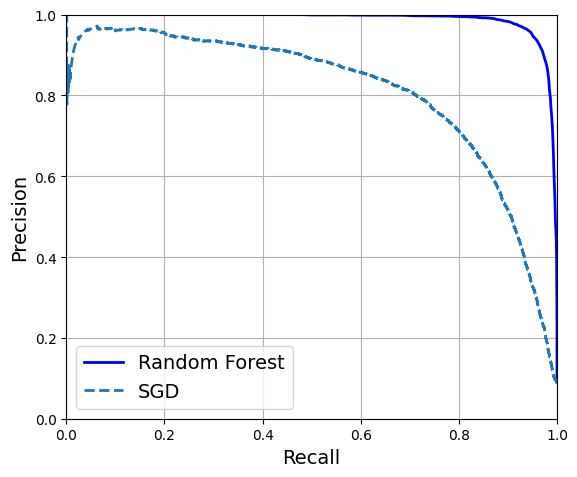

In [62]:
plt.figure(figsize=(6, 5))

plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2, label="Random Forest")
plt.plot(recalls, precisions, "--", linewidth=2, label="SGD")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")
save_fig("pr_curve_comparison_plot")

plt.show()

_Figure: Comparing PR curves: the random forest classifier is superior to the SGD classifier because its PR curve is much closer to the top-right corner, and it has a greater AUC_

The `RandomForestClassifier`'s F1 score and ROC AUC score are also significantly better. We could use `cross_val_predict(forest_clf, X_train, y_train_5, cv=3)` to compute `y_train_pred_forest`, but since we already have the estimated probabilities, we can just use the default threshold of 50% probability to get the same predictions much faster:

In [64]:
y_train_pred_forest = y_probas_forest[:, 1] >= 0.5 # positive proba ≥ 50%
f1_score(y_train_5, y_train_pred_forest)

0.9274509803921569

In [65]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [66]:
precision_score(y_train_5, y_train_pred_forest)

0.9897468089558485

In [67]:
recall_score(y_train_5, y_train_pred_forest)

0.8725327430363402

# Multiclass Classification